<a href="https://colab.research.google.com/github/JALB-epsilon/CAAM554_Codes/blob/main/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#It contains all the problem from the HW8.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1pP5pHMfckEC276BiMVpqe7evKY93Yz5h?authuser=2#scrollTo=FRejukNlDfeN)

##Setting Libraries

In [ ]:
import jax 
import jax.numpy as jnp
from jax import grad, hessian, jit, jacfwd, jacrev
from jax import random, device_put
import matplotlib.pyplot as plt
key = random.PRNGKey(10)

In [ ]:
#If you want to run it in a GPU (though is not needed), 
#Go to Runtime->Change runtime type -> Hardware accelerator.
jax.devices()

[GpuDevice(id=0, task=0)]

#Problem 2 iii

In [ ]:
#Rosenbrock's function
def Rosenbrock(x):
    if len(x)%2==1: print(f"The input has dimension {n}, it is not even and f is undefined")
    else:
      return jnp.sum(100.0*(x[::2]**2.0-x[1::2])**2.0 + (x[::2]-1)**2.0)
#Compiling the function into the device
jit_Rosenbrock= jit(Rosenbrock)
#Obtaining the gradient and then compiling
jit_grad_R = jit(grad(jit_Rosenbrock)) 
#Calculating the hessian
jit_Hess_R = jit(hessian(jit_Rosenbrock))

In [ ]:
x =jnp.array([1.,2.,1.,2.])


In [ ]:
jit_Rosenbrock(x)

DeviceArray(200., dtype=float32)

In [ ]:
jit_grad_R(x)

DeviceArray([-400.,  200., -400.,  200.], dtype=float32)

In [ ]:
jit_Hess_R(x)

DeviceArray([[ 402., -400.,    0.,    0.],
             [-400.,  200.,    0.,    0.],
             [   0.,    0.,  402., -400.],
             [   0.,    0., -400.,  200.]], dtype=float32)

In [ ]:
jax.hessian(jit_Rosenbrock)(x)

DeviceArray([[ 402., -400.,    0.,    0.],
             [-400.,  200.,    0.,    0.],
             [   0.,    0.,  402., -400.],
             [   0.,    0., -400.,  200.]], dtype=float32)

#**Gradient Descent**

In [ ]:
dim = 2400
#x = device_put(2.*jnp.ones(dim))
x = device_put(random.uniform(key, (dim,)))

In [ ]:
def grad_descent(x =x,
                 jit_grad = jit_grad_R,
                 alpha =0.001, 
                 tol = 1e-7,
                 maxIt =5000, 
                 PrintVar =100,
                 PrintX = None,
                 save_files = None,
                 x_sol = jnp.empty_like(x)
                 ):
  n = len(x)
  if n < 20: 
    print(f"x_0 = {x}")
  if save_files: 
    val_x = []
    val_grad= []
    iter = []
  for i in range(maxIt): 
      grad = jit_grad(x)
      grad_norm =jnp.linalg.norm(grad,ord=2)
      x += alpha*(-grad)
      if i%PrintVar ==0: 
          print(f"iteration: {i}, grad_norm: {grad_norm}" )
          if PrintX: 
              print(f"x: {x}")
          if save_files:
            error_x = jnp.linalg.norm(x-x_sol,ord=2)
            val_x.append(error_x)
            val_grad.append(grad_norm)
            iter.append(i)
      if grad_norm< tol:
          print("****************************************")
          print(f"stop because grad_norm= {grad_norm} < {tol}")
          break   
      if jnp.isnan(grad_norm):
          print("****************************************")
          print(f"stop because grad_norm= {grad_norm}, GD method diverges")
          break           
  print("****************************************")
  if n< 20: 
    print(f"iteration: {i}, grad_norm: {grad_norm}, \nx={x}")
  else: 
    print(f"iteration: {i}, grad_norm: {grad_norm}")
  if save_files:
    return val_x, val_grad, iter,x
  else:
    return x
    

In [ ]:
dim = 2400
#x = device_put(2.*jnp.ones(dim))
x = device_put(random.uniform(key, (dim,)))
x_sol = grad_descent(x,
                     alpha =0.0015, 
                     maxIt =20000, 
                     PrintVar =1000)

iteration: 0, grad_norm: 4474.787109375
iteration: 1000, grad_norm: 5.953736782073975
iteration: 2000, grad_norm: 2.5994491577148438
iteration: 3000, grad_norm: 1.2923781871795654
iteration: 4000, grad_norm: 0.6756989359855652
iteration: 5000, grad_norm: 0.3617098331451416
iteration: 6000, grad_norm: 0.19595323503017426
iteration: 7000, grad_norm: 0.10682351142168045
iteration: 8000, grad_norm: 0.058429520577192307
iteration: 9000, grad_norm: 0.03202449157834053
iteration: 10000, grad_norm: 0.01758413575589657
iteration: 11000, grad_norm: 0.009690620936453342
iteration: 12000, grad_norm: 0.005382090341299772
iteration: 13000, grad_norm: 0.003039146773517132
iteration: 14000, grad_norm: 0.001798881683498621
iteration: 15000, grad_norm: 0.0011619004653766751
iteration: 16000, grad_norm: 0.0008002925314940512
iteration: 17000, grad_norm: 0.0008002925314940512
iteration: 18000, grad_norm: 0.0008002925314940512
iteration: 19000, grad_norm: 0.0008002925314940512
*****************************

In [ ]:
x_sol

DeviceArray([0.9999782, 0.9999563, 0.9999782, ..., 0.9999563, 0.9999782,
             0.9999563], dtype=float32)

#### After increasing the number of iterations, since the function has been compiled in the device used (CPU, TPU or GPU). There is no problem to increasing the number of iterations to improve the accuracy.
## **Results Gradient Descent**
Gradient Descent is converging towards the vector of 1s. 
$\mathbb{1} = [1,1, \ldots, 1]^\top.$




#**Newton Method**

In [ ]:
def newton_method(x,
                 jit_grad = jit_grad_R,
                 jit_hess = jit_Hess_R,
                 alpha =1, 
                 tol = 1e-7,
                 maxIt =5000, 
                 PrintVar =100,
                 PrintX = None,
                 save_files = None,
                 x_sol = jnp.empty_like(x)
                 ):
  n =len(x)
  if n < 20: 
    print(f"x_0 = {x}")
  if save_files: 
    val_x = []
    val_grad= []
    iter = []
  for i in range(maxIt):
    grad = jit_grad(x)
    hess = jit_hess(x)
    grad_norm =jnp.linalg.norm(grad,ord=2)
    s = jnp.linalg.solve(hess, -grad)
    x+= alpha*s
    if i%PrintVar ==0: 
      print(f"iteration: {i}, grad_norm: {grad_norm}" )
      if PrintX: 
          print(f"x: {x}")
      if save_files:
        error_x = jnp.linalg.norm(x-x_sol,ord=2)
        val_x.append(error_x)
        val_grad.append(grad_norm)
        iter.append(i)
    if grad_norm< tol:
        print("****************************************")
        print(f"stop because grad_norm= {grad_norm}< {tol}")
        break            
    if jnp.isnan(grad_norm):
        print("****************************************")
        print(f"stop because grad_norm= {grad_norm}, Newton method diverges")
        break    
  print("****************************************")
  if n< 20: 
    print(f"iteration: {i}, grad_norm: {grad_norm}, \nx={x}")
  else: 
    print(f"iteration: {i}, grad_norm: {grad_norm}")
  if save_files:
    return val_x, val_grad, iter, x
  else:
    return x

In [ ]:
dim = 2400
#x = device_put(2.*jnp.ones(dim))
x = device_put(random.uniform(key, (dim,)))
x_sol = newton_method(x, 
                      alpha =1, 
                      maxIt =100,
                      PrintVar =1)

iteration: 0, grad_norm: 4474.787109375
iteration: 1, grad_norm: 777541.0
iteration: 2, grad_norm: 6201.5859375
iteration: 3, grad_norm: 57524.40234375
iteration: 4, grad_norm: 488.4939880371094
iteration: 5, grad_norm: 148.23716735839844
iteration: 6, grad_norm: 132.2191925048828
iteration: 7, grad_norm: 44.55080032348633
iteration: 8, grad_norm: 1.195596694946289
iteration: 9, grad_norm: 0.043701332062482834
iteration: 10, grad_norm: 2.6656007321435027e-05
iteration: 11, grad_norm: 0.0
****************************************
stop because grad_norm= 0.0< 1e-07
****************************************
iteration: 11, grad_norm: 0.0


In [ ]:
x_sol

DeviceArray([1., 1., 1., ..., 1., 1., 1.], dtype=float32)

#### After increasing the number of iterations, since the function has been compiled in the device used (CPU, TPU or GPU). There is no problem to increasing the number of iterations to improve the accuracy.
## **Results Newton Method**
Newton Method is converes towards the vector of 1s. 
$\mathbb{1} = [1,1, \ldots, 1]^\top.$

##Plotting



In [ ]:
dim = 2400
xinit= device_put(2*jnp.ones(dim))
x_sol = device_put(jnp.ones(dim))
val_x_gd, val_grad_gd, iter_gd, x_sol_gd = grad_descent(xinit, 
                                              alpha =0.0015, 
                                              maxIt =5000, 
                                              save_files= 1, 
                                              PrintVar =300,
                                              x_sol= x_sol)

iteration: 0, grad_norm: 57198.640625
iteration: 300, grad_norm: 65.82535552978516
iteration: 600, grad_norm: 76.35863494873047
iteration: 900, grad_norm: 29.017656326293945
iteration: 1200, grad_norm: 15.958819389343262
iteration: 1500, grad_norm: 10.603938102722168
iteration: 1800, grad_norm: 7.633800983428955
iteration: 2100, grad_norm: 5.74131965637207
iteration: 2400, grad_norm: 4.437344551086426
iteration: 2700, grad_norm: 3.4932456016540527
iteration: 3000, grad_norm: 2.7862625122070312
iteration: 3300, grad_norm: 2.243938446044922
iteration: 3600, grad_norm: 1.8204666376113892
iteration: 3900, grad_norm: 1.4852899312973022
iteration: 4200, grad_norm: 1.2172218561172485
iteration: 4500, grad_norm: 1.001060962677002
iteration: 4800, grad_norm: 0.8256186842918396
****************************************
iteration: 4999, grad_norm: 0.7275000214576721


In [ ]:
dim = 2400
xinit= device_put(2.*jnp.ones(dim))
val_x_newton, val_grad_newton, iter_newton, x_sol_newton = newton_method(xinit, 
                                                                    alpha =1, 
                                                                    maxIt =100, 
                                                                    save_files= 1, 
                                                                    PrintVar =2, 
                                                                    x_sol = x_sol)

iteration: 0, grad_norm: 57198.640625
iteration: 2, grad_norm: 15392.5283203125
iteration: 4, grad_norm: 0.022161388769745827
****************************************
stop because grad_norm= 0.0< 1e-07
****************************************
iteration: 5, grad_norm: 0.0


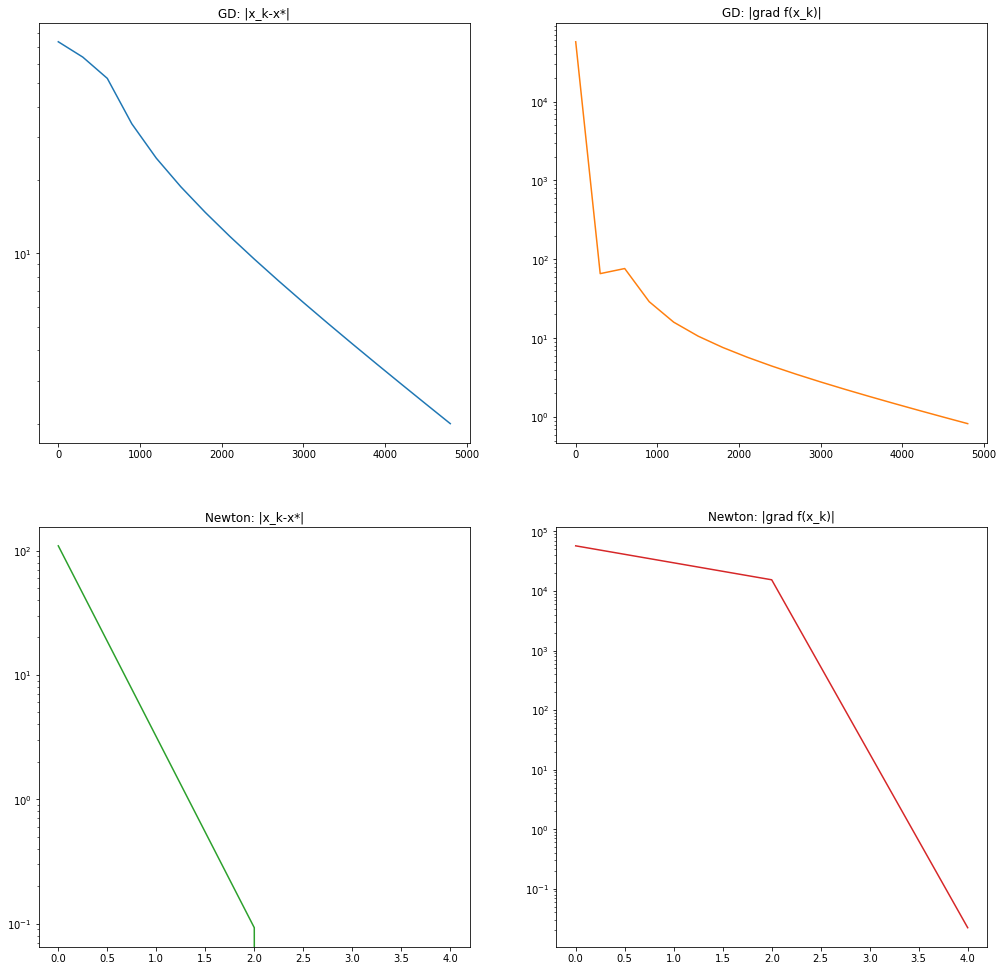

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,17))
axs[0, 0].plot(iter_gd, val_x_gd)
axs[0, 0].set_title('GD: |x_k-x*|')
axs[0, 0].set_yscale('log')
axs[0, 1].plot(iter_gd, val_grad_gd, 'tab:orange')
axs[0, 1].set_title('GD: |grad f(x_k)|')
axs[0, 1].set_yscale('log')

axs[1, 0].plot(iter_newton, val_x_newton, 'tab:green')
axs[1, 0].set_title('Newton: |x_k-x*|')
axs[1, 0].set_yscale('log')
axs[1, 1].plot(iter_newton, val_grad_newton, 'tab:red')
axs[1, 1].set_title('Newton: |grad f(x_k)|')
axs[1, 1].set_yscale('log')


#Problem 1 iii

In [ ]:
@jit
#Defining the exponential to work of vectors
def f(x):
  return jnp.exp(x)
jacobian_f = jacrev(f)  #using AD
hess_f = hessian(f)     #using AD
#One Side Finite Difference
def first_oneSide_FD(f, x, eps = 1e-3):
   return jnp.array([(f(x + eps * v) - f(x)) / (eps)
                   for v in jnp.eye(len(x))])
#First Centered Finite Difference
def first_centered_FD(f, x, eps = 1e-3):
   return jnp.array([(f(x + eps * v) - f(x - eps * v)) / (2 * eps)
                   for v in jnp.eye(len(x))])
#Second Centered Finite Difference  
def second_centered_FD(f, x, eps = 1e-3):
   Id =jnp.eye(len(x))
   return jnp.array([((f(x + eps * v)- 2*f(x) + f(x - eps * v)) / (eps**2))*Id
                   for v in Id])

In [ ]:
x = jnp.array([3., 1., 4.])

In [ ]:
jacobian_f(x)

DeviceArray([[20.085537 ,  0.       ,  0.       ],
             [ 0.       ,  2.7182817,  0.       ],
             [ 0.       ,  0.       , 54.59815  ]], dtype=float32)

In [ ]:
first_centered_FD(f,x)

DeviceArray([[20.083426 ,  0.       ,  0.       ],
             [ 0.       ,  2.7183292,  0.       ],
             [ 0.       ,  0.       , 54.594036 ]], dtype=float32)

In [ ]:
#Asked in the exercise
from jax.config import config; config.update("jax_enable_x64", True)
x = jnp.array([1.], dtype=jnp.float64)
deriv = jacobian_f(x)
hess = hess_f(x)


In [ ]:
#Set up the error
def error(fapprox, f, exact):
  vec = jnp.array([fapprox(f, x, eps = 10**(-(i+1))) for  i in range(20)])
  return jnp.abs(vec-exact)


In [ ]:
eps_vec =[10**(-(i+1)) for  i in range(20)]
error_1st_sided_DF = error(fapprox = first_oneSide_FD, f=f, exact = deriv).flatten()
error_1st_central_DF = error(fapprox = first_centered_FD, f=f, exact = deriv).flatten()
error_2nd_cental_DF = error(fapprox = second_centered_FD, f=f, exact = hess).flatten()

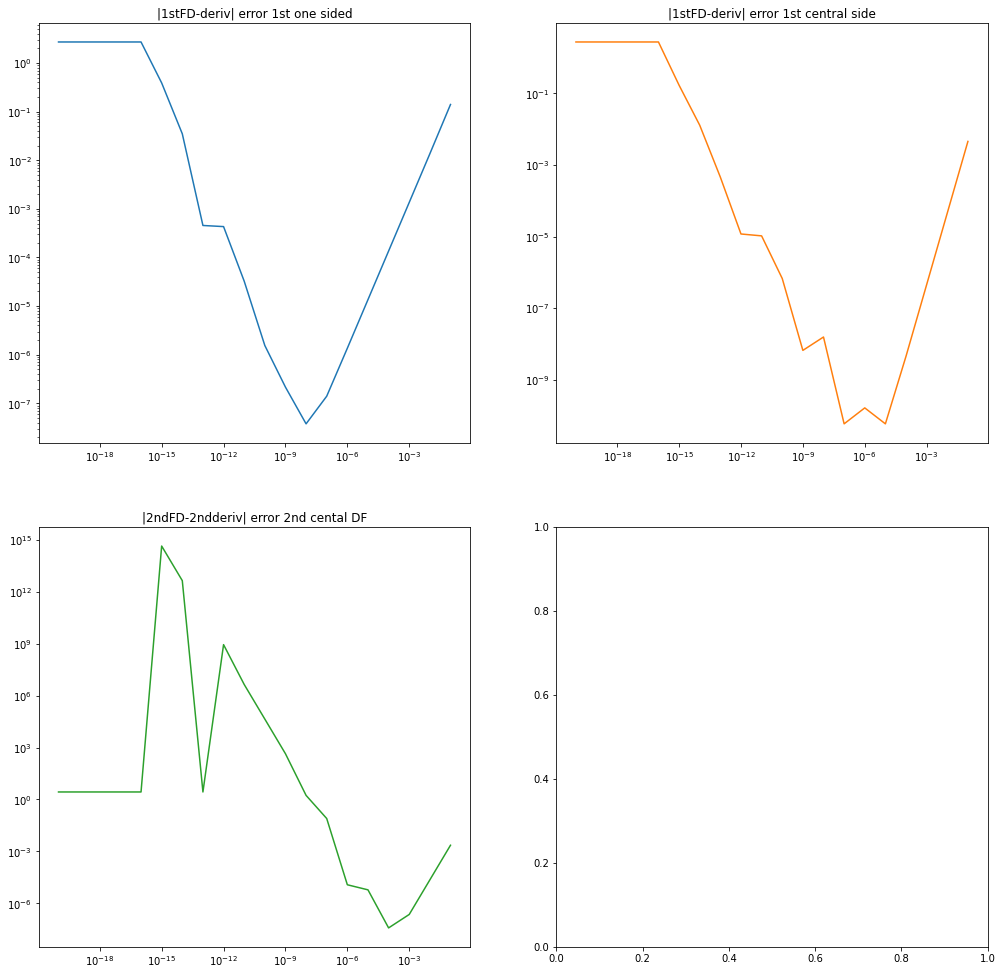

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,17))
axs[0, 0].plot(eps_vec, error_1st_sided_DF)
axs[0, 0].set_title('|1stFD-deriv| error 1st one sided')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xscale('log')
axs[0, 1].plot(eps_vec, error_1st_central_DF, 'tab:orange')
axs[0, 1].set_title('|1stFD-deriv| error 1st central side')
axs[0, 1].set_yscale('log')
axs[0, 1].set_xscale('log')
axs[1, 0].plot(eps_vec, error_2nd_cental_DF, 'tab:green')
axs[1, 0].set_title('|2ndFD-2ndderiv| error 2nd cental DF')
axs[1, 0].set_yscale('log')
axs[1, 0].set_xscale('log')


#Problem 3 i and ii


In [ ]:
#Defining the function of the problem
def func_probl_3(x):
  return (x[0]-2)**4+((x[0]-2)**2)*x[1]**2+(x[1]+1)**2
#Compiling to improve performance
jit_func_3 = jit(func_probl_3)
#gradient
jit_grad_f_3 = jit(grad(jit_func_3))
#hessian
jit_hess_f_3 = jit(hessian(jit_func_3))


In [ ]:
#starting value
x = device_put(jnp.array([1.,1.]))
x_sol_3 = device_put(jnp.array([2.,-1.]))

In [ ]:
#minimizing func_probl_3 by GD at [1.,1.]
val_x_gd, val_grad_gd, iter_gd, x_sol_gd = grad_descent(x,
                                                jit_grad = jit_grad_f_3,
                                                alpha =0.001, 
                                                tol = 1e-7,
                                                maxIt =5000, 
                                                PrintVar =300,
                                                x_sol = x_sol_3,
                                                save_files= 1
                                                )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.48528137423857
iteration: 300, grad_norm: 2.0816355915943956
iteration: 600, grad_norm: 1.0829161517657588
iteration: 900, grad_norm: 0.6654694492868903
iteration: 1200, grad_norm: 0.44061192377992053
iteration: 1500, grad_norm: 0.2888982643733806
iteration: 1800, grad_norm: 0.18113710568180313
iteration: 2100, grad_norm: 0.10849322013201136
iteration: 2400, grad_norm: 0.06278541069920551
iteration: 2700, grad_norm: 0.03552896098479327
iteration: 3000, grad_norm: 0.019835160387467625
iteration: 3300, grad_norm: 0.010987410174170592
iteration: 3600, grad_norm: 0.006059530045897524
iteration: 3900, grad_norm: 0.0033336098542855984
iteration: 4200, grad_norm: 0.0018314699317667125
iteration: 4500, grad_norm: 0.0010054470564430397
iteration: 4800, grad_norm: 0.0005517464649766561
****************************************
iteration: 4999, grad_norm: 0.000370513743748045, 
x=[ 1.99986324 -0.99987552]


In [ ]:
#minimizing func_probl_3 by Newton at [1.,1.]
val_x_newton, val_grad_newton, iter_newton, x_sol_newton = newton_method(x,
                                                                  jit_grad = jit_grad_f_3,
                                                                  jit_hess = jit_hess_f_3,
                                                                  alpha =1, 
                                                                  tol = 1e-15,
                                                                  maxIt =5000, 
                                                                  PrintVar =1 ,
                                                                  x_sol = x_sol_3,
                                                                  save_files= 1
                                                                  )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.48528137423857
iteration: 1, grad_norm: 4.5
iteration: 2, grad_norm: 1.4941565678058275
iteration: 3, grad_norm: 0.5233879412189747
iteration: 4, grad_norm: 0.1014010888447795
iteration: 5, grad_norm: 0.002555612918113977
iteration: 6, grad_norm: 3.319064059945663e-06
iteration: 7, grad_norm: 2.808149089867246e-12
iteration: 8, grad_norm: 0.0
****************************************
stop because grad_norm= 0.0< 1e-15
****************************************
iteration: 8, grad_norm: 0.0, 
x=[ 2. -1.]


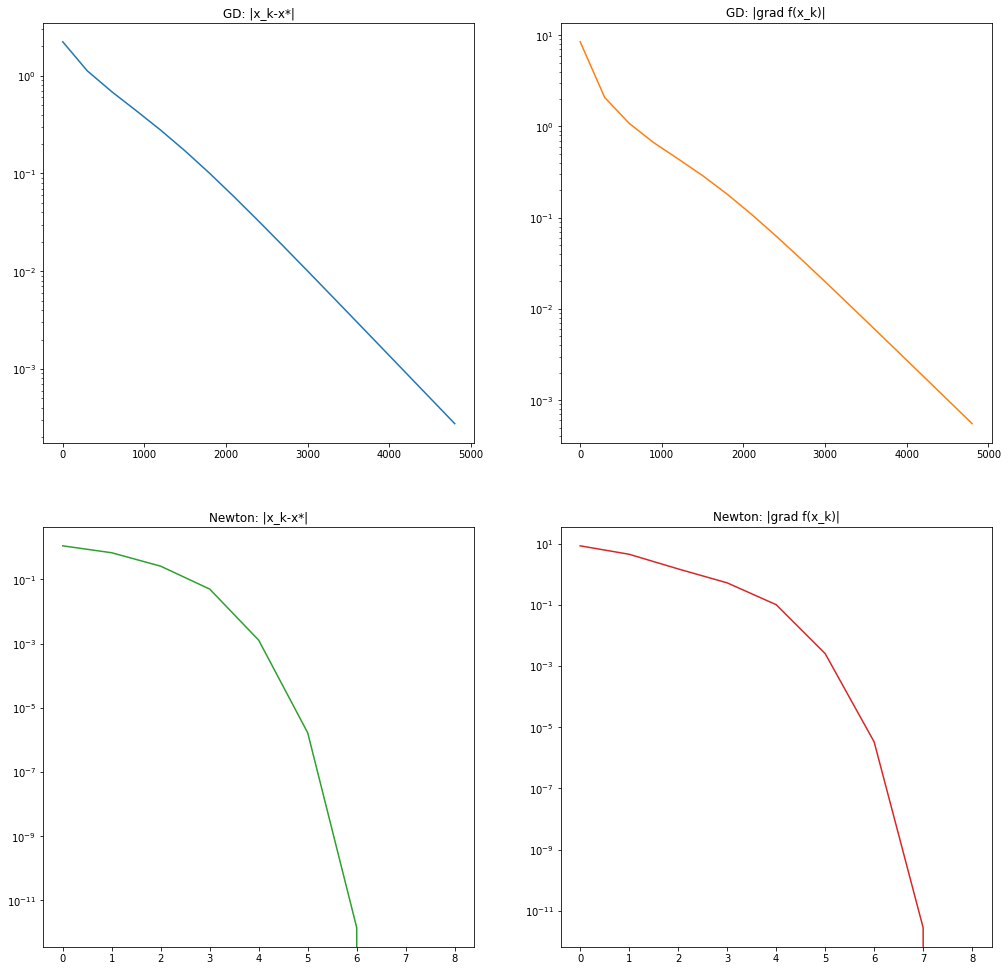

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,17))
axs[0, 0].plot(iter_gd, val_x_gd)
axs[0, 0].set_title('GD: |x_k-x*|')
axs[0, 0].set_yscale('log')
axs[0, 1].plot(iter_gd, val_grad_gd, 'tab:orange')
axs[0, 1].set_title('GD: |grad f(x_k)|')
axs[0, 1].set_yscale('log')

axs[1, 0].plot(iter_newton, val_x_newton, 'tab:green')
axs[1, 0].set_title('Newton: |x_k-x*|')
axs[1, 0].set_yscale('log')
axs[1, 1].plot(iter_newton, val_grad_newton, 'tab:red')
axs[1, 1].set_title('Newton: |grad f(x_k)|')
axs[1, 1].set_yscale('log')

###Problem 3 ii Using FD


In [ ]:
#defining the hessian for the case of two dimension
def hess_prob_3(f, x, eps1 = 1e-3, eps2= 1e-3):
   Id =jnp.eye(len(x)); hess = []
   for v in Id:
     for w in Id:
       approx = (f(x+eps1*v+eps2*w)-f(x+eps1*v)-f(x+eps2*w)+f(x))/(eps1*eps2)
       hess.append(approx)
   return jnp.reshape(jnp.array(hess), (2,2))

#setting the hessian ready to the newton method 
def hess_func_probl_3_approx(x, f= func_probl_3, eps1 = 1e-1, eps2= 1e-1):
  return hess_prob_3(f=func_probl_3, x=x, eps1 = eps1, eps2 = eps2)


In [ ]:
#GD using the the grad approx.
#reusing our previous algorithm for approx. the gradient
def approx_1(x, f= func_probl_3, eps = 1e-1):
  return first_oneSide_FD(f= func_probl_3, x= x, eps = eps)
def approx_2(x, f= func_probl_3, eps = 1e-3):
  return first_oneSide_FD(f= func_probl_3, x= x, eps = eps)
#hessian
def hess_aprox1(x, f= func_probl_3, eps1 = 1e-1, eps2= 1e-1):
  return hess_prob_3(f=func_probl_3, x=x, eps1 = eps1, eps2 = eps2)
#hessian 2
def hess_aprox2(x, f= func_probl_3, eps1 = 1e-3, eps2= 1e-3):
  return hess_prob_3(f=func_probl_3, x=x, eps1 = eps1, eps2 = eps2)

### Using GD

In [ ]:
#approx1 GD
val_x_gd1, val_grad_gd1, iter_gd1, x_sol_gd1 = grad_descent(x,
                                                jit_grad = approx_1,
                                                alpha =0.001, 
                                                tol = 1e-7,
                                                maxIt =200, 
                                                PrintVar =5,
                                                x_sol = x_sol_3,
                                                save_files= 1
                                                )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.18198759471072
iteration: 5, grad_norm: 7.729043986871324
iteration: 10, grad_norm: 7.329128706074202
iteration: 15, grad_norm: 6.973729028516473
iteration: 20, grad_norm: 6.65598648216252
iteration: 25, grad_norm: 6.370322981874899
iteration: 30, grad_norm: 6.1121628015138185
iteration: 35, grad_norm: 5.8777230688719975
iteration: 40, grad_norm: 5.663853984569375
iteration: 45, grad_norm: 5.467915615451365
iteration: 50, grad_norm: 5.287681926999501
iteration: 55, grad_norm: 5.121265335672707
iteration: 60, grad_norm: 4.967056883695805
iteration: 65, grad_norm: 4.823678424517415
iteration: 70, grad_norm: 4.689944126227206
iteration: 75, grad_norm: 4.564829265019909
iteration: 80, grad_norm: 4.447444767002266
iteration: 85, grad_norm: 4.33701631592095
iteration: 90, grad_norm: 4.23286711245536
iteration: 95, grad_norm: 4.13440357254742
iteration: 100, grad_norm: 4.041103405494984
iteration: 105, grad_norm: 3.9525056298414563
iteration: 110, grad

In [ ]:
#approx2
val_x_gd2, val_grad_gd2, iter_gd2, x_sol_gd2 = grad_descent(x,
                                                jit_grad = approx_2,
                                                alpha =0.001, 
                                                tol = 1e-7,
                                                maxIt =200, 
                                                PrintVar =5,
                                                x_sol = x_sol_3,
                                                save_files= 1
                                                )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.481751053409862
iteration: 5, grad_norm: 7.963565915629608
iteration: 10, grad_norm: 7.5101559323164775
iteration: 15, grad_norm: 7.1106187157546525
iteration: 20, grad_norm: 6.756269684599414
iteration: 25, grad_norm: 6.440117052748327
iteration: 30, grad_norm: 6.1564777457321975
iteration: 35, grad_norm: 5.900692239975385
iteration: 40, grad_norm: 5.66890999014583
iteration: 45, grad_norm: 5.4579259861115315
iteration: 50, grad_norm: 5.265054856503167
iteration: 55, grad_norm: 5.088032893896095
iteration: 60, grad_norm: 4.924941086454385
iteration: 65, grad_norm: 4.774144123840528
iteration: 70, grad_norm: 4.634241671862189
iteration: 75, grad_norm: 4.504029157058104
iteration: 80, grad_norm: 4.382465986092535
iteration: 85, grad_norm: 4.2686496241391945
iteration: 90, grad_norm: 4.161794324821036
iteration: 95, grad_norm: 4.061213578835724
iteration: 100, grad_norm: 3.9663055548243866
iteration: 105, grad_norm: 3.876540962621128
iteration: 11

##using Newton

In [ ]:
#aprox1
val_x_newton1, val_grad_newton1, iter_newton1, x_sol_newton1 = newton_method(x,
                                                                  jit_grad = approx_1,
                                                                  jit_hess = hess_aprox1,
                                                                  alpha =1, 
                                                                  tol = 1e-7,
                                                                  maxIt =20, 
                                                                  PrintVar =1 ,
                                                                  x_sol = x_sol_3,
                                                                  save_files= 1
                                                                  )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.18198759471072
iteration: 1, grad_norm: 5.724249179812536
iteration: 2, grad_norm: 1.5948405939196209
iteration: 3, grad_norm: 0.4202233058419464
iteration: 4, grad_norm: 0.04609761069139644
iteration: 5, grad_norm: 0.003240423002691186
iteration: 6, grad_norm: 0.00014457565753476316
iteration: 7, grad_norm: 2.954944376813179e-06
iteration: 8, grad_norm: 5.302959608118144e-08
****************************************
stop because grad_norm= 5.302959608118144e-08< 1e-07
****************************************
iteration: 8, grad_norm: 5.302959608118144e-08, 
x=[ 1.95       -1.04750623]


In [ ]:
#aprox2
val_x_newton2, val_grad_newton2, iter_newton2, x_sol_newton2 = newton_method(x,
                                                                  jit_grad = approx_2,
                                                                  jit_hess = hess_aprox2,
                                                                  alpha =1, 
                                                                  tol = 1e-7,
                                                                  maxIt =20, 
                                                                  PrintVar =1 ,
                                                                  x_sol = x_sol_3,
                                                                  save_files= 1
                                                                  )

x_0 = [1. 1.]
iteration: 0, grad_norm: 8.481751053409862
iteration: 1, grad_norm: 4.507834628522382
iteration: 2, grad_norm: 1.4942864103100708
iteration: 3, grad_norm: 0.5221607733958142
iteration: 4, grad_norm: 0.10054919539945185
iteration: 5, grad_norm: 0.002449085201935266
iteration: 6, grad_norm: 8.772096750213977e-07
iteration: 7, grad_norm: 7.059998455603334e-10
****************************************
stop because grad_norm= 7.059998455603334e-10< 1e-07
****************************************
iteration: 7, grad_norm: 7.059998455603334e-10, 
x=[ 1.9995     -1.00049975]


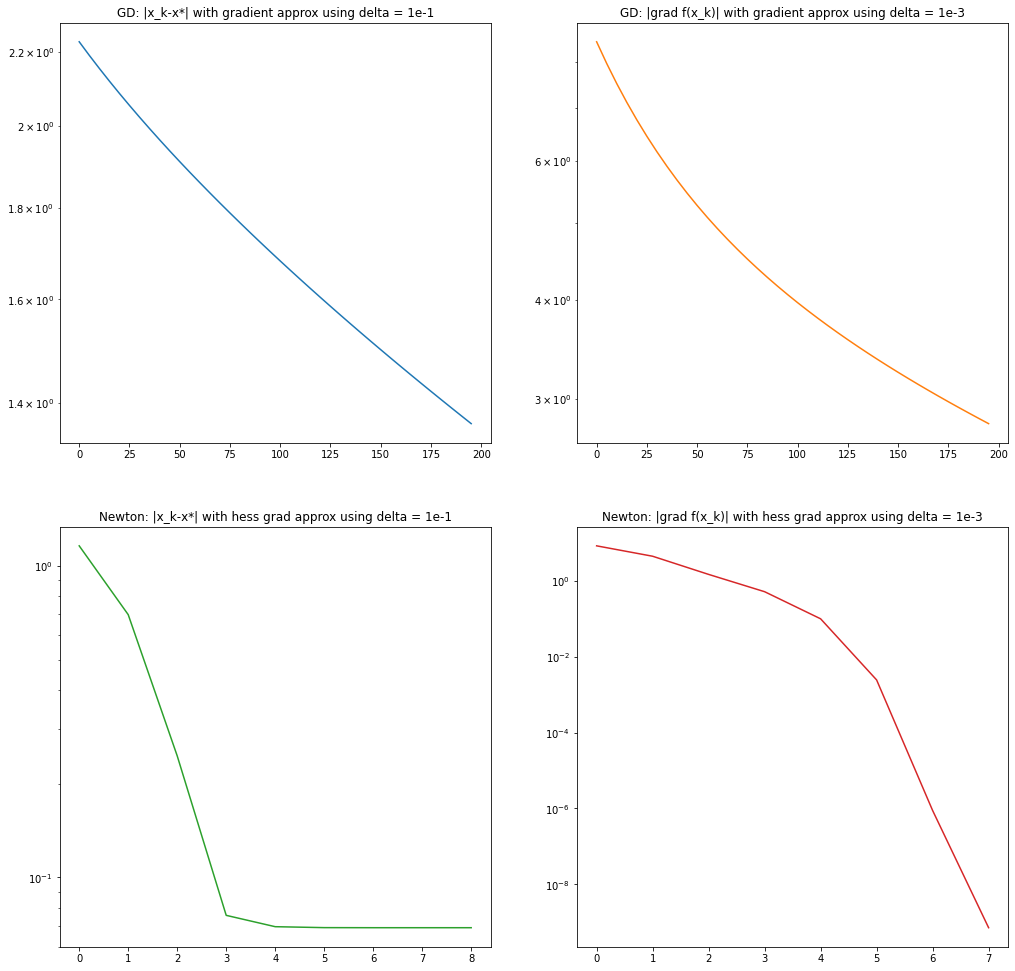

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(17,17))
axs[0, 0].plot(iter_gd1, val_x_gd1)
axs[0, 0].set_title('GD: |x_k-x*| with gradient approx using delta = 1e-1')
axs[0, 0].set_yscale('log')
axs[0, 1].plot(iter_gd2, val_grad_gd2, 'tab:orange')
axs[0, 1].set_title('GD: |grad f(x_k)| with gradient approx using delta = 1e-3')
axs[0, 1].set_yscale('log')

axs[1, 0].plot(iter_newton1, val_x_newton1, 'tab:green')
axs[1, 0].set_title('Newton: |x_k-x*| with hess grad approx using delta = 1e-1')
axs[1, 0].set_yscale('log')
axs[1, 1].plot(iter_newton2, val_grad_newton2, 'tab:red')
axs[1, 1].set_title('Newton: |grad f(x_k)| with hess grad approx using delta = 1e-3')
axs[1, 1].set_yscale('log')